In [1]:
using Images, FileIO, PyPlot
"""
Parameters we can learn
    Gaussian comparison
        Spread
         
    Center^p minus (average of corners)^q
        p
        q
    
    Vetting the kernel
        Threshold for sum of entire kernel
        Other methods with other parameters?
            
    
    Kernel size
        5, 7 or 9
    
    Final threshold
        t
    
Other things to think about
    Normalize the image between 0-1 or normalize the kernel between 0-1? Would this make a difference? 
    Combine methods? For example, standard deviation + center minus corners?

    Three dimensionality
        Should we do the dice function on the stack (voxel) level or on the slice (pixel) level? 
        Could we do the slice level and then somehow use this to create, train and execute the slice level?

    Training data
        Would it be worth it to hand-annote not just the center of each focus, but each individual pixel? 
        Or should the method be robust enough in the first place to not need that?

"""

In [84]:
function ddfload(filename)
    # Loads the entire stack of 7 and returns a normalized (0-1) Array{Float64}
    img = load(filename)
    img = Float64.(img)
    img = img .- minimum(img)
    img = img./maximum(img)
    return Float64.(img)
end

function MIP(img)
    img = Float32.(img)
    img = maximum(img, 3)
    img = Float64.(img)
    return img[:, :, 1]
end


function weightedcentroid(focus)
    # Calculate the weighted centroid coordinates
    m = size(focus, 1)
    n = size(focus, 2)

    xsum = sum(focus, 1)
    ysum = sum(focus, 2)
    
    
    weightedsumx = 1*xsum[2]
    for i = 2:n
       weightedsumx = weightedsumx + i*xsum[i] # tack on i*xsum[i]
    end
    
    Cx = weightedsumx/sum(xsum)
    
    weightedsumy = 1*ysum[2]
    
    for i = 2:n
       weightedsumy = weightedsumy + i*ysum[i]
    end
    
    Cy = weightedsumy/sum(ysum)
    
    return (Cx, Cy)
    
end


function generateidealgaussian(m, n, spread, z, Cx, Cy)
    sigmax = spread
    sigmay = spread
    m = z*m
    n = z*n
    x0 = z*Cx
    y0 = z*Cy

    gauss = zeros(m, n)
    
    for x = 1:m

        for y = 1:n
            a = ((x-x0)^2)/(2*sigmax^2)
            b = ((y-y0)^2)/(2*sigmay^2)
            gauss[x, y] = exp(-( (a) + (b) ))
        end
    end
    
    
    # Normalize
#     gauss = gauss - minimum(gauss)
#     gauss = gauss./maximum(gauss)
    return Float64.(gauss)
end

function discretizegaussian(G, m, n, z)
    # return m x n to be overlaid
    # for now use averaging
    
    Gdiscrete = zeros(m, n)
    
    for x = 1:m
        for y = 1:n
            
            
            
            mstart = 1 + z*(x-1)
            mend = x*z
            nstart = 1 + z*(y-1)
            nend = y*z

            chunk = G[mstart:mend, nstart:nend]
            if x == 3 & y == 1
               singlechunk = chunk
            end
            
            Gdiscrete[x, y] = sum(chunk) / (length(chunk))
            
        end
    end

    return Gdiscrete
end

function vetkernel(kernel, thresh)

    if sum(kernel) < thresh # If it didn't make the threshold
        return false
    else # If it did, get the weighted centroid then make the new box
        return true
    end
    
    return true

end

# Try out different score heuristics here

function comparetogaussian(kernel, Cx, Cy, z, spread)
    # Generate a m x n gaussian 
    spread = z*2
    score = 0
   
    if kernel != false && Cx != false
        (m, n) = size(kernel)
                
        G = generateidealgaussian(m, n, spread, z, Cx, Cy)
        G = G 
        # Make amplitude equal to max of focus
        Gdiscrete = discretizegaussian(G, m, n, z)
        if size(Gdiscrete) != size(kernel)
          score = 0 
        else
            score = sum((Gdiscrete .- kernel)^2)
        end

    end 
    
    return score
end

function stdscore(newfocus)
    if newfocus != false
        return std(vec(newfocus))
    else
        return 0
    end
end

function centerminuscorner(newfocus)
    if newfocus != false
        return newfocus[3, 3] - (1/4)*(newfocus[1, 1] + newfocus[size(newfocus, 1), 1] + newfocus[1, size(newfocus, 2)] + newfocus[size(newfocus, 1), size(newfocus, 2)])
    else
        return 0
    end
end

function centerovercorner(newfocus)
    if newfocus != false
        return ((newfocus[3, 3])^2) / (1/4)*(newfocus[1, 1] + newfocus[size(newfocus, 1), 1] + newfocus[1, size(newfocus, 2)] + newfocus[size(newfocus, 1), size(newfocus, 2)])
    else
        return 0
    end
end

function normalize01(img)
    img = img - minimum(img)
    img = img./maximum(img)
    return Float64.(img)
end

function plot3things(A, B, C)
    fig = figure("pyplot_subplot_mixed",figsize=(18, 10)) # Create a new blank figure
    subplot(131)
    title("Thing A")
    PyPlot.imshow(A)
    
    subplot(132) # Create the second plot of a 3x1 group of subplots
    title("Thing B")
    PyPlot.imshow(B)
    
    subplot(133)
    title("Thing C")
    PyPlot.imshow(C)
end

plot3things (generic function with 1 method)

In [137]:
function main(file)
    # Load and do a MIP
    img = ddfload(file)
    img = MIP(img)

    n = 7 # kernel size
    z = 10 # resolution of gaussian
    r = Int16.((n-1)/2)
    
    poss = 0
    count = 0
    
    thresh = 1.5
    
    # Have to start at [3, 3] for a 5x5 kernel 
    xstart = round((n/2)+1)
    xend = size(img, 1) - xstart
    ystart = round((n/2)+1)
    yend = size(img, 2) - ystart
    xstart = Int16.(xstart)
    xend = Int16.(xend)
    ystart = Int16.(ystart)
    yend = Int16.(yend)


    scores = zeros(size(img))
    stdev = zeros(size(img))
    spread = 3
    
    for x = xstart:xend
        for y = ystart:yend
            kernel = img[x-r:x+r,y-r:y+r]
            if vetkernel(kernel, 1.5) == false
                scores[x, y] = 0
            else
                Cx, Cy = weightedcentroid(kernel)
                scores[x, y] = centerminuscorner(kernel)
            end
            
        end
    end
    
    scores = normalize01(scores)
    
    fig = figure("pyplot_subplot_mixed",figsize=(12, 4)) # Create a new blank figure
    subplot(131)
    title("Original Image MIP")
    PyPlot.imshow(img)
    suptitle("Image Intensities")
    
    subplot(132) # Create the second plot of a 3x1 group of subplots
    title("Scored pixels")
    PyPlot.imshow(scores)
    
    subplot(133)
    title("Thresholded of the scored")
    PyPlot.imshow(scores.>=.3)
end

main (generic function with 1 method)

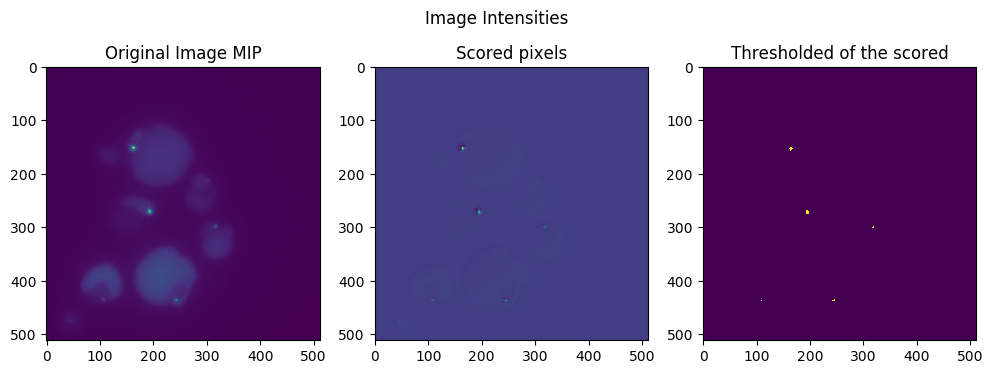

PyObject <matplotlib.image.AxesImage object at 0x14f610950>

In [138]:
main("GFP_005.tif")

#PyPlot.imshow(im.>0.7) to threshold
# PyPlot.imshow(MIP(ddfload("RFP_003.tif")))